# Single-Label Classification for Document Image Layout Classification

## Dataset Reader
The ImageDataset class reads images and their corresponding labels. Images are stored in the random_imgs_limited folder containing subfolders 0, 1, 2, 3, and their corresponding labels are integers (0, 1, 2, or 3) stored in the Class column of the image_binary_components.csv file.

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, Subset
import glob
import numpy as np

class ImageDataset(Dataset):
    def __init__(self, data_dir, img_size=256):
        self.data_dir = data_dir
        self.img_size = img_size

        # Read the CSV file
        self.df = pd.read_csv(os.path.join(data_dir, 'image_binary_components.csv'))

        # Collect image filenames from the subdirectories
        subdirs = [f.path for f in os.scandir(os.path.join(data_dir, 'random_imgs_limited')) if f.is_dir()]
        filenames = []
        for subdir in subdirs:
            filenames.extend(glob.glob(os.path.join(subdir, '*.jpg')))

        self.df['filename'] = ''
        for index, row in self.df.iterrows():
            try:
                filename = next(x for x in filenames if row['Image name'] in x)
                self.df.at[index, 'filename'] = filename
            except StopIteration:
                pass

        # Define image transformations
        self.transforms = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_file = self.df.loc[idx, 'filename']
        img_label = int(self.df.loc[idx, 'Class'])  # Single integer label

        img = Image.open(img_file).convert('RGB')
        img = self.transforms(img)

        return img, img_label


## Splitting the Dataset and Customizing the Network
The dataset is split into training, validation, and testing subsets. The last layer of the VGG-16 model is modified to output four logits corresponding to the four classes (0, 1, 2, 3).

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import vgg16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

batch_size = 16
num_epochs = 10

# Load dataset
dataset = ImageDataset('drive/My Drive/Colab Notebooks/midrash_layout_classification_using_multilabel_vgg-main/data')

# Define split percentages
train_percentage, val_percentage, test_percentage = 0.8, 0.1, 0.1

# Split dataset
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.seed(11)
np.random.shuffle(indices)

n_train = int(np.floor(train_percentage * dataset_size))
n_val = int(np.floor(val_percentage * dataset_size))

train_subset = Subset(dataset, indices[:n_train])
val_subset = Subset(dataset, indices[n_train:n_train + n_val])
test_subset = Subset(dataset, indices[n_train + n_val:])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Load VGG-16 and modify last layer
vgg = vgg16(pretrained=True)
num_features = vgg.classifier[-1].in_features
vgg.classifier[-1] = nn.Linear(num_features, 4)  # Four classes
vgg.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=0.0001)


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Visualize random samples and their labels
Display a sample of images and their corresponding labels from the training dataset.

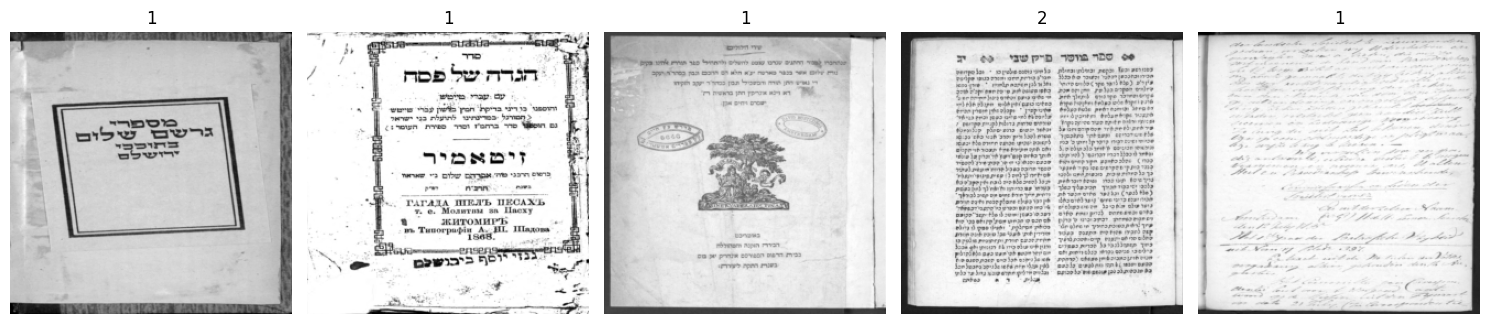

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of sample images from the train loader
sample_images, sample_labels = next(iter(train_loader))

# Convert images to numpy array for display
sample_images = sample_images.numpy()

# Extract the first 5 images and labels from the batch
sample_images = sample_images[:5]
sample_labels = sample_labels[:5]

# Convert the labels tensor to a numpy array for display
sample_labels = sample_labels.numpy()

# Create a figure with subplots for each sample image
fig, axs = plt.subplots(nrows=1, ncols=len(sample_images), figsize=(15, 5))

# Display each image and label using the corresponding subplot
for i in range(len(sample_images)):
    # Convert the image to grayscale
    grayscale_image = np.squeeze(sample_images[i]).mean(axis=0)
    axs[i].imshow(grayscale_image, cmap='gray')
    axs[i].set_axis_off()
    title = str(sample_labels[i])
    axs[i].set_title(title)

# Show the plot
plt.tight_layout()
plt.show()

## Training the Model
The training loop updates the model's parameters using the training dataset and evaluates its performance on the validation set.

In [4]:
# Train the model
vgg.to(device)
best_val_loss = float('inf') # Initialize with a very high value
print(f"Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    running_loss = 0.0
    print(f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in train_loader:
        #print(f"Processing batch {batch_idx+1}/{len(train_loader)}")
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = vgg(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1} loss: {epoch_loss:.4f}')

    # Evaluate the model on validation set
    vgg.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = vgg(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    print(f'Epoch {epoch+1} validation loss: {epoch_val_loss:.4f}')

    # Update best_val_loss and save model if the current validation loss is lower than the previous min
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(vgg.state_dict(), 'drive/My Drive/Colab Notebooks/midrash_layout_classification_using_multilabel_vgg-main/best_model.pth')

    vgg.train()

Starting training for 10 epochs...
Epoch 1/10
Epoch 1 loss: 0.6321
Epoch 1 validation loss: 0.4392
Epoch 2/10
Epoch 2 loss: 0.2459
Epoch 2 validation loss: 0.2718
Epoch 3/10
Epoch 3 loss: 0.1964
Epoch 3 validation loss: 0.2227
Epoch 4/10
Epoch 4 loss: 0.1531
Epoch 4 validation loss: 0.2883
Epoch 5/10
Epoch 5 loss: 0.1008
Epoch 5 validation loss: 0.3777
Epoch 6/10
Epoch 6 loss: 0.0530
Epoch 6 validation loss: 0.4621
Epoch 7/10
Epoch 7 loss: 0.0619
Epoch 7 validation loss: 0.5281
Epoch 8/10
Epoch 8 loss: 0.0999
Epoch 8 validation loss: 0.2957
Epoch 9/10
Epoch 9 loss: 0.0492
Epoch 9 validation loss: 0.2923
Epoch 10/10
Epoch 10 loss: 0.0189
Epoch 10 validation loss: 0.3976


## Testing
Load the model with the least validation loss

In [5]:
vgg.load_state_dict(torch.load('drive/My Drive/Colab Notebooks/midrash_layout_classification_using_multilabel_vgg-main/best_model.pth'))

<ipython-input-5-d03315c2a9b2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg.load_state_dict(torch.load('drive/My Drive/Colab Notebooks/midrash_layout_classification_

<All keys matched successfully>

## Visualizing Predictions

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode
vgg.to(device)
vgg.eval()

# Generate 15 random indices for the test set
random_idx = random.sample(range(len(test_subset)), 15)

# Loop through each index and predict the label for that image
for idx in random_idx:
    # Get image and label from test set
    image, label = test_subset[idx]

    # Move the image to the device
    image = image.unsqueeze(0).to(device)  # No need to recreate a tensor

    # Forward pass through the model to get predicted label
    output = vgg(image)
    pred = torch.argmax(output, dim=1).item()  # Get the predicted class index

    # Print ground truth and predicted label
    print(f"Ground Truth: {label}, Predicted Label: {pred}")

    # Plot the image with predicted and ground truth label as title
    plt.imshow(image[0].cpu().permute(1, 2, 0).numpy())
    plt.title(f"GT: {label}, Pred: {pred}")
    plt.axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

##Calculate the accuracy

In [7]:
# Set model to evaluation mode
vgg.eval()

# Generate predicted labels and true labels for the test set
test_labels_pred = []
test_labels_true = []

# Use DataLoader for the test set to ensure proper batch handling
test_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

for image, label in test_loader:
    # Move image and label to device
    image = image.to(device)
    label = label.to(device)

    # Forward pass through the model to get logits
    output = vgg(image)

    # Get predicted class (index of max logit)
    pred = torch.argmax(output, dim=1).item()
    test_labels_pred.append(pred)

    # Save true label
    test_labels_true.append(label.item())

# Convert to numpy arrays for further analysis
test_labels_pred = np.array(test_labels_pred)
test_labels_true = np.array(test_labels_true)


In [8]:
def accuracy(y_true, y_pred):
    correct_count = np.sum(y_true == y_pred)  # Count matching elements
    acc = correct_count / len(y_true)        # Compute accuracy
    return acc

# Calculate accuracy
acc = accuracy(test_labels_true, test_labels_pred)
print(f"Test Accuracy: {acc * 100:.2f}%")


Test Accuracy: 94.85%
